# Deep Learning - Gesture Recognition Case Study #

### Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
 
| Gesture | Corresponding Action |
| --- | --- | 
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |

Each video is a sequence of 30 frames (or images).

### Sections:

0. **Initial EDA** This section
1. **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. We will start training on a small amount of data and then proceed further.

3. **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model.

In [1]:
#Install Few Dependencies if not available and validated versions

#!pip install Pillow
#!pip install imageio
#!pip install scikit-image
#!pip install tensorflow
#!pip install keras
print("*"*30)
print("Versions")
print("*"*30)
!pip freeze | grep 'scipy\|keras\|tensorflow'
!nvidia-smi

******************************
Versions
******************************
horovod @ file:///opt/tensorflow/horovod-source/dist/horovod-0.20.2.tar.gz
scipy==1.4.1
tensorflow @ file:///tmp/pip/tensorflow-2.3.1%2Bnv-cp36-cp36m-linux_x86_64.whl
tensorflow-addons @ file:///opt/tensorflow/tf-addons/artifacts/tensorflow_addons-0.11.2-cp36-cp36m-linux_x86_64.whl
tensorflow-datasets==3.2.1
tensorflow-estimator==2.3.0
tensorflow-metadata==0.25.0
Sat Jul 31 14:07:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+==================

In [2]:
#Import the necessary Libraries

import numpy as np
import os
from timeit import default_timer as timer
import scipy
from skimage.transform import resize
import datetime
import os
from tensorflow import keras
import tensorflow as tf
import random
import glob
import cv2
import matplotlib.pyplot as plt

In [3]:
#Initialize Paths
#help(os)
#pwd = os.getcwd()
#print(pwd)

project_folder = '/datasets/Project_data'
#project_folder= '/Users/sreesree/Documents/Vinisha/MS_Sree/Real/Gesture_Recognition/Project_data'
train_image_metadata=project_folder+'/train.csv'
val_image_metadata=project_folder+'/val.csv'

We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(30)
random.seed(30)
tf.random.set_seed(30)

## 0. Initial EDA 

In this block, we read the folder names for training and validation. We will set the `batch_size` as part of class parameter. Note that we set the batch size in such a way that we are able to use the GPU in full capacity. We keep on increasing the batch size until the machine throws an error.

In [5]:
train_doc = np.random.permutation(open(train_image_metadata).readlines())
val_doc = np.random.permutation(open(val_image_metadata).readlines())


In [6]:
# function to plot n images using subplots
def plot_image(images, captions=None, cmap=None ):
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(15)
    for ax,image in zip(axes, images):
        ax.imshow(image, cmap)

/datasets/Project_data/train/WIN_20180925_17_49_45_Pro_Right_Swipe_new/*


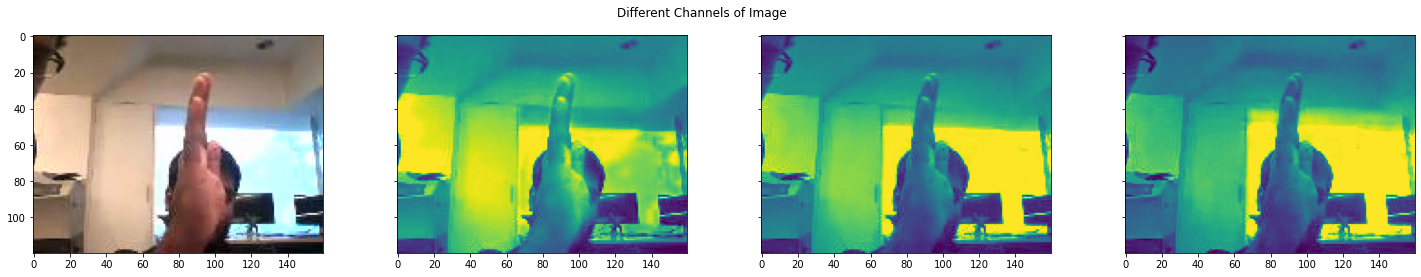

In [7]:
# run this block multiple times to look at some randomly chosen images 
rand_index = random.randint(0, len(train_doc)) # Find a random video folder 
train_path = project_folder+'/train/'+train_doc[rand_index].split(';')[0]+'/*'
print(train_path)
train_path = glob.glob(train_path) # Glob all 30 images of the folder
rand_index = random.randint(0, len(train_path))
image = cv2.imread(train_path[rand_index]) #Read a random image from the selected folder
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
f.set_figwidth(25)
ax1.imshow(image)

# RGB channels
ax2.imshow(image[:, : , 0])
ax3.imshow(image[:, : , 1])
ax4.imshow(image[:, : , 2])
f.suptitle('Different Channels of Image')
plt.show()

(120, 160, 3)


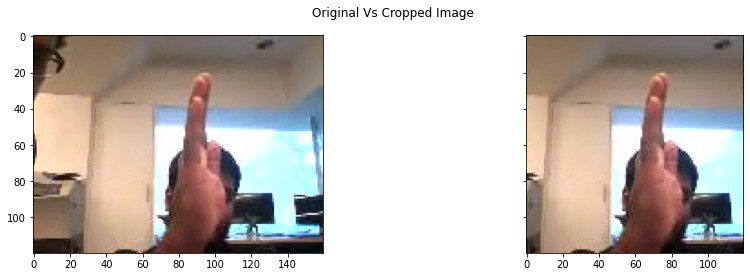

In [8]:
print(image.shape)
crop_image=image[0:120,20:140]
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figwidth(15)
ax1.imshow(image)

# RGB channels
ax2.imshow(crop_image)
f.suptitle('Original Vs Cropped Image')
plt.show()

In [25]:
fliplr_thumbdown_path = glob.glob('/datasets/Project_data/train/WIN_20180925_17_57_52_Pro_Thumbs_Down_new/*')
fliplr_thumbup_path= glob.glob('/datasets/Project_data/train/WIN_20180925_17_22_42_Pro_Thumbs_Up_new/*')
fliplr_rightswipe_path=glob.glob('/datasets/Project_data/train/WIN_20180925_17_49_45_Pro_Right_Swipe_new/*')
fliplr_leftswipe_path=glob.glob('/datasets/Project_data/train/WIN_20180926_16_48_34_Pro_Left_Swipe_new/*')
crop_left_swipe = glob.glob('/datasets/Project_data/train/WIN_20180925_17_40_41_Pro_Left_Swipe_new/*')
#for path in crop_left_swipe:
#    image = cv2.imread(path) #Read a random image from the selected folder
#    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
#    f.set_figwidth(15)
#    ax1.imshow(image)
#    ax2.imshow(image[0:120,20:140])
#    f.suptitle('Original Image Vs Cropped Image')
    
    
#plt.close('all')
#plt.clf()

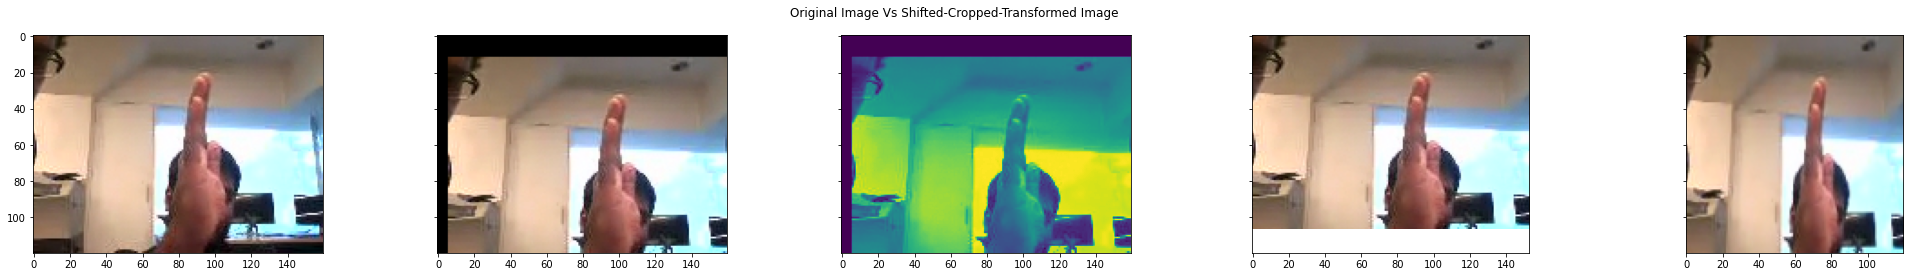

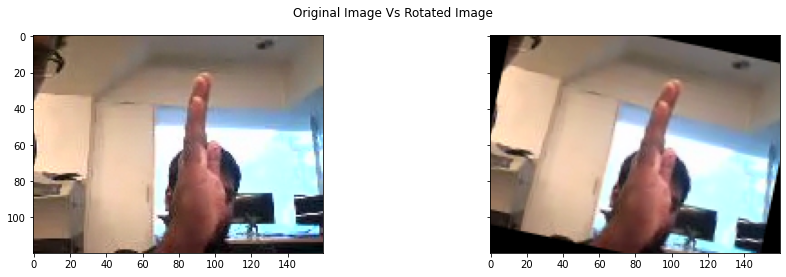

In [26]:
rows, cols = image.shape[:2]
 
# #https://towardsdatascience.com/transformations-with-opencv-ff9a7bea7f8b
#We’ll build a transformation matrix that will contain the information to transform the image. 
#For simplification, we can think of this matrix as    
    
#[[size, rotation, location], ←x-axis
#[rotation, size, location]] ←y-axis
# So default matrix will be
#[[1, 0, 0]
# [0, 1, 0]]
#That means, 100% of the size, zero rotation, and no change in the location 

# build a transformation matrix for changing location
matrix = [[1, 0, np.random.randint(-30,30)], #x 
          [0, 1, np.random.randint(-30,30)]] #y
M = np.float32(matrix)


# Apply the affine transformation using cv2.warpAffine()
shifted = cv2.warpAffine(image, M, (cols,rows))

gray = cv2.cvtColor(shifted,cv2.COLOR_RGB2GRAY)

x0, y0 = np.argwhere(gray > 0).min(axis=0)
x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                  
cropped=shifted[x0:x1,y0:y1,:]


transfored_image = cv2.resize(cropped, (120,120), interpolation = cv2.INTER_AREA)


rot_matrix = cv2.getRotationMatrix2D((cols//2,rows//2),
                                                np.random.randint(-20,20), 1)
rot_M = np.float32(rot_matrix)

# Apply the affine transformation using cv2.warpAffine()
rotated = cv2.warpAffine(image, rot_M, (cols,rows))

f, (ax1, ax2, ax3, ax4,ax5) = plt.subplots(1, 5, sharey=True)
f.set_figwidth(35)
ax1.imshow(image)
ax2.imshow(shifted)
ax3.imshow(gray)
ax4.imshow(cropped)
ax5.imshow(transfored_image)

f.suptitle('Original Image Vs Shifted-Cropped-Transformed Image')
plt.show()

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figwidth(15)
ax1.imshow(image)
ax2.imshow(rotated)
f.suptitle('Original Image Vs Rotated Image')
plt.show()


## 1. Generator
In the generator, we are going to preprocess the images as we have images of 2 different dimensions as well as create a batch of video frames. We will experiment with `img_idx`, `y`,`z` and normalization such that we get high accuracy.

In [9]:
#Base Class for all the classes with common functionality
import abc
class BaseModel(metaclass=abc.ABCMeta):
    
    
    def __init__(self):
        # object attributes
        self.name = 'Green'
        self.timing_cb = self.TimingCallback()        
        
        
    #initialize the path for the train and validation images
    #This will be called by each inherited class
    def initialize_path(self, project_folder):
        self.train_doc = np.random.permutation(open(train_image_metadata).readlines())
        self.val_doc = np.random.permutation(open(val_image_metadata).readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    
    #initialize the properties of each image
    #We will standardize all image using the 
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
    
    #initalize the training parameters, this will be used by  each model to train 
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    def generator(self, source_path, folder_list, augment=False):
        batch_size = self.batch_size
        #print('Source path = ', source_path)
        #print('batch size =', batch_size)
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        while True:
            t = np.random.permutation(folder_list)
            #print("t : ", t)
            num_batches =  len(t)//batch_size
            #print("num_batches", num_batches)
            
            for batch in range(num_batches): # we iterate over the number of batches
                batch_data, batch_labels= self.one_batch_data_generator(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 
                
            
            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data_generator(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
                
                
    
    def one_batch_data_generator(self, source_path, t, batch, batch_size, img_idx, augment, remaining_seq=0):
        
        #Initialize the seq length
        seq_len = remaining_seq if remaining_seq else batch_size
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
        batch_labels = np.zeros((seq_len,self.num_classes)) # batch_labels is the one hot representation of the output

        
        if (augment): 
            batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))
            batch_data_rot = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))
        
        for folder in range(seq_len): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    # 360 x 360 and 120 x 160 and 
                    # the conv3D will throw error if the inputs in a batch have different shapes
                    
                    # Crop the image which doesn't have aspect ratio of 1
                    # In the data set 120x160 will be those, we will adjust the width by trimming
                    # 20 pixels from both left and right side and making it a 120x120 image
                    if image.shape[0] != image.shape[1]:
                        image=image[0:120,20:140]
                        
                    #As we are shrinking the image so using Interpolation as "INTER_AREA"
                    image_resized = cv2.resize(image, (self.image_width, self.image_height), interpolation = cv2.INTER_AREA)
           
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255

                    if (augment):
                        # #https://towardsdatascience.com/transformations-with-opencv-ff9a7bea7f8b
                        #We’ll build a transformation matrix that will contain the information to 
                        #transform the image. 
                        #For simplification, we can think of this matrix as    
    
                        #[[size, rotation, location], ←x-axis
                        #[rotation, size, location]] ←y-axis
                        # So default matrix will be
                        #[[1, 0, 0]
                        # [0, 1, 0]]
                        #That means, 100% of the size, zero rotation, and no change in the location 

                        # build a transformation matrix
                        # We will do random location change in the range of -30 to 30 for both x and y axis
                        translation_matrix = np.array([
                                 [1, 0, np.random.randint(-30,30)], #x 
                                 [0, 1, np.random.randint(-30,30)]  #y
                        ], dtype=np.float32) 
                                                
                        rows, cols = image.shape[:2] # Height, Width
                        # Apply the affine transformation using cv2.warpAffine()
                        # cv2 needs dimensions in Width, Height formats
                        transformed = cv2.warpAffine(image, translation_matrix, (cols,rows))
                        
                        #Convert to grayscale to crop out black borders if any
                        gray = cv2.cvtColor(transformed,cv2.COLOR_RGB2GRAY)

                        # Find min and max from pixels whose intensity is not zero.
                        # Black will be zero
                        x0, y0 = np.argwhere(gray > 0).min(axis=0)
                        x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                        cropped=transformed[x0:x1,y0:y1,:]
                    
                        image_resized = cv2.resize(cropped, (self.image_width, self.image_height), interpolation = cv2.INTER_AREA)
                      
                        batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                        batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                        batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                        
                        #Rotate image at an angle between -10 to 10 
                        rotate_matrix = cv2.getRotationMatrix2D((cols//2,rows//2),
                                                np.random.randint(-10,10), 1.0)
                        rotated = cv2.warpAffine(image, rotate_matrix, (cols, rows)) 
                        
                        rotated_resized = cv2.resize(rotated, (self.image_width, self.image_height), interpolation = cv2.INTER_AREA)
                        
                        batch_data_rot[folder,idx,:,:,0] = (rotated_resized[:,:,0])/255
                        batch_data_rot[folder,idx,:,:,1] = (rotated_resized[:,:,1])/255
                        batch_data_rot[folder,idx,:,:,2] = (rotated_resized[:,:,2])/255
                                               
    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

        #Add to the augmentated labels also if augmented is true
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_data=np.concatenate([batch_data,batch_data_rot])
            batch_labels=np.tile(batch_labels,(3,1)) # Create Label by repeating the batch_label 3 times
            

        return (batch_data, batch_labels)
    
    def train_model(self, model, augment_data = False):
        train_generator = self.generator(self.train_path, self.train_doc, augment= augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)
        
        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
        
        if not os.path.exists(model_name):
            os.mkdir(model_name)
            
        filepath = 'model_init' + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}--{val_categorical_accuracy:.5f}.h5'
        
        #HyperParameter Tuners
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
        LR = ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1)
        earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)
        
        callbacks_list = [checkpoint, LR, earlystop, self.timing_cb]
        
        #The `steps_per_epoch` and `validation_steps` are used by 
        #fit_generator to decide the number of next() calls it need to make.
        
        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
            
        history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history   
    
    
    #Class to calculate the time taken for training each epoch
    class TimingCallback(keras.callbacks.Callback):
        def __init__(self, logs={}):
            self.logs=[]
        def on_epoch_begin(self, epoch, logs={}):
            self.starttime = timer()
        def on_epoch_end(self, epoch, logs={}):
            self.logs.append(timer()-self.starttime)
          
    
    @abc.abstractmethod
    def define_model(self):
        pass   
    
    

#### Plotting Function for Results ####

In [10]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## 2. Model
Here we will make the model using different functionalities that Keras provides. We will use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. 
We will also try building a `Conv2D + RNN model`. The last layer is the softmax. We will try to design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [11]:
#Common Import for Models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers



## 2.1 - 3D CNN Architecture ##
### Initial Model : 0

In [18]:
class ModelConv3D_Inital(BaseModel):
    
    def define_model(self, optimizer='Adam'):
        model = Sequential()
        model.add(Conv3D(16, (3,3,3), padding='same',
                        input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(32,(2,2,2), padding='same'))
        
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        model.add(Dense(self.num_classes,activation='softmax'))
        
        #optimizer = optimizers.Adam()
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

Assembling Initial Model :

In [31]:
conv3d_initial = ModelConv3D_Inital()
conv3d_initial.initialize_path(project_folder)
conv3d_initial.initialize_image_properties(image_height=160, image_width=160)
conv3d_initial.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=1)
conv3d_initial_model = conv3d_initial.define_model()
conv3d_initial_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 16, 160, 160, 16)  1312      
_________________________________________________________________
activation_4 (Activation)    (None, 16, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 8, 80, 80, 16)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 8, 80, 80, 32)     4128      
_________________________________________________________________
activation_5 (Activation)    (None, 8, 80, 80, 32)     0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 80, 80, 32)    

Validating if this model compiles

In [32]:
conv3d_initial.train_model(conv3d_initial_model)

23/23 [==============================] - ETA: 0s - loss: 1.8666 - categorical_accuracy: 0.3590
Epoch 00001: val_loss improved from inf to 2.99083, saving model to model_initmodel-00001-1.86660-0.35897-2.99083--0.15000.h5
23/23 [==============================] - 39s 2s/step - loss: 1.8666 - categorical_accuracy: 0.3590 - val_loss: 2.9908 - val_categorical_accuracy: 0.1500


**Observation**  : We have now created an initial model which is compilable.


We shall now look at an optimum **initial** value for all the hyperparameters which gives us a good balance between time taken and accuracy.
- **Step 1**:  We will find the Optimum Value by analysing **Epoch Time** by, with changing few parameters linearly, and while keeping others fixed. This will be done. This will help us analyse the tradeoff of varying these values, and fix the initial values for the parameters
- **Step 2**: Next, Using these parameters we will first train for 20 epochs and see if the Training Set overlearns, which means that the model is working, when we shall move to step 3
- **Step 3** We will now look at various parameters and architectures in that order, and try to optimise it to reduce loss and increase training effeciency


### Step 1: Tradeoff Analysis
Analysing Tradeoff between Image Resolution, Number of Images and Batch Size

**Approach** : We will first Decrease the Batch Parameters,then Increase the Resolution of the Images, and then play around with the Frames. 
At each step, We will analyse the time for each Epoch and Total time, to see if this makes a difference to the training time.  Using this we will try to guestimate the parameters we should start with

We will use limited epochs, for the training as that is not important for this experiment

In [33]:
#Baseline
conv3d_initial = ModelConv3D_Inital()
conv3d_initial.initialize_path(project_folder)
conv3d_initial.initialize_image_properties(image_height=100, image_width=100)
conv3d_initial.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=3)
conv3d_initial_model = conv3d_initial.define_model()
#conv3d_initial_model.summary()
conv3d_initial.train_model(conv3d_initial_model)
print("Per Epoch time  {}".format(conv3d_initial.timing_cb.logs))
print("Total Time: {}".format(sum(conv3d_initial.timing_cb.logs)))


Epoch 1/3
23/23 [==============================] - ETA: 0s - loss: 1.8719 - categorical_accuracy: 0.3801
Epoch 00001: val_loss improved from inf to 2.33516, saving model to model_initmodel-00001-1.87192-0.38009-2.33516--0.16000.h5
23/23 [==============================] - 33s 1s/step - loss: 1.8719 - categorical_accuracy: 0.3801 - val_loss: 2.3352 - val_categorical_accuracy: 0.1600
Epoch 2/3
23/23 [==============================] - ETA: 0s - loss: 1.2541 - categorical_accuracy: 0.5234
Epoch 00002: val_loss did not improve from 2.33516
23/23 [==============================] - 33s 1s/step - loss: 1.2541 - categorical_accuracy: 0.5234 - val_loss: 4.2166 - val_categorical_accuracy: 0.1600
Epoch 3/3
22/23 [===========================>..] - ETA: 1s - loss: 0.9908 - categorical_accuracy: 0.6364
Epoch 00003: val_loss did not improve from 2.33516
23/23 [==============================] - 32s 1s/step - loss: 0.9885 - categorical_accuracy: 0.6365 - val_loss: 5.1319 - val_categorical_accuracy: 0.170

In [34]:
#Reduce Batch Size from 30 to 20
conv3d_initial = ModelConv3D_Inital()
conv3d_initial.initialize_path(project_folder)
conv3d_initial.initialize_image_properties(image_height=100, image_width=100)
conv3d_initial.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=3)
conv3d_initial_model = conv3d_initial.define_model()
#conv3d_initial_model.summary()
conv3d_initial.train_model(conv3d_initial_model)
print("Per Epoch time  {}".format(conv3d_initial.timing_cb.logs))
print("Total Time: {}".format(sum(conv3d_initial.timing_cb.logs)))

Epoch 1/3
34/34 [==============================] - ETA: 0s - loss: 1.8632 - categorical_accuracy: 0.3710
Epoch 00001: val_loss improved from inf to 3.01571, saving model to model_initmodel-00001-1.86323-0.37104-3.01571--0.21000.h5
34/34 [==============================] - 34s 995ms/step - loss: 1.8632 - categorical_accuracy: 0.3710 - val_loss: 3.0157 - val_categorical_accuracy: 0.2100
Epoch 2/3
34/34 [==============================] - ETA: 0s - loss: 1.3599 - categorical_accuracy: 0.5113
Epoch 00002: val_loss did not improve from 3.01571
34/34 [==============================] - 34s 1s/step - loss: 1.3599 - categorical_accuracy: 0.5113 - val_loss: 4.9673 - val_categorical_accuracy: 0.1900
Epoch 3/3
34/34 [==============================] - ETA: 0s - loss: 1.1691 - categorical_accuracy: 0.5520
Epoch 00003: val_loss did not improve from 3.01571
34/34 [==============================] - 34s 998ms/step - loss: 1.1691 - categorical_accuracy: 0.5520 - val_loss: 4.4379 - val_categorical_accuracy:

In [35]:
#Reduce Image Size from 100 to 84
conv3d_initial = ModelConv3D_Inital()
conv3d_initial.initialize_path(project_folder)
conv3d_initial.initialize_image_properties(image_height=84, image_width=84)
conv3d_initial.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=3)
conv3d_initial_model = conv3d_initial.define_model()
#conv3d_initial_model.summary()
conv3d_initial.train_model(conv3d_initial_model)
print("Per Epoch time  {}".format(conv3d_initial.timing_cb.logs))
print("Total Time: {}".format(sum(conv3d_initial.timing_cb.logs)))

Epoch 1/3
34/34 [==============================] - ETA: 0s - loss: 2.0595 - categorical_accuracy: 0.3560
Epoch 00001: val_loss improved from inf to 2.18086, saving model to model_initmodel-00001-2.05950-0.35596-2.18086--0.16000.h5
34/34 [==============================] - 32s 935ms/step - loss: 2.0595 - categorical_accuracy: 0.3560 - val_loss: 2.1809 - val_categorical_accuracy: 0.1600
Epoch 2/3
34/34 [==============================] - ETA: 0s - loss: 1.3308 - categorical_accuracy: 0.5490
Epoch 00002: val_loss did not improve from 2.18086
34/34 [==============================] - 32s 930ms/step - loss: 1.3308 - categorical_accuracy: 0.5490 - val_loss: 3.9131 - val_categorical_accuracy: 0.1500
Epoch 3/3
34/34 [==============================] - ETA: 0s - loss: 1.0999 - categorical_accuracy: 0.5928
Epoch 00003: val_loss did not improve from 2.18086
34/34 [==============================] - 32s 950ms/step - loss: 1.0999 - categorical_accuracy: 0.5928 - val_loss: 4.4223 - val_categorical_accura

In [36]:
#Reduce Image Size from 100 to 84 and Sample all data
conv3d_initial = ModelConv3D_Inital()
conv3d_initial.initialize_path(project_folder)
conv3d_initial.initialize_image_properties(image_height=84, image_width=84)
conv3d_initial.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=3)
conv3d_initial_model = conv3d_initial.define_model()
#conv3d_initial_model.summary()
conv3d_initial.train_model(conv3d_initial_model)
print("Per Epoch time  {}".format(conv3d_initial.timing_cb.logs))
print("Total Time: {}".format(sum(conv3d_initial.timing_cb.logs)))

Epoch 1/3
34/34 [==============================] - ETA: 0s - loss: 2.0262 - categorical_accuracy: 0.3333
Epoch 00001: val_loss improved from inf to 1.78172, saving model to model_initmodel-00001-2.02622-0.33333-1.78172--0.17000.h5
34/34 [==============================] - 59s 2s/step - loss: 2.0262 - categorical_accuracy: 0.3333 - val_loss: 1.7817 - val_categorical_accuracy: 0.1700
Epoch 2/3
34/34 [==============================] - ETA: 0s - loss: 1.4737 - categorical_accuracy: 0.4691
Epoch 00002: val_loss did not improve from 1.78172
34/34 [==============================] - 59s 2s/step - loss: 1.4737 - categorical_accuracy: 0.4691 - val_loss: 3.2175 - val_categorical_accuracy: 0.1700
Epoch 3/3
34/34 [==============================] - ETA: 0s - loss: 1.1057 - categorical_accuracy: 0.5928
Epoch 00003: val_loss did not improve from 1.78172
34/34 [==============================] - 59s 2s/step - loss: 1.1057 - categorical_accuracy: 0.5928 - val_loss: 5.4387 - val_categorical_accuracy: 0.140

In [37]:
#Increase Image Resolution to 160
conv3d_initial = ModelConv3D_Inital()
conv3d_initial.initialize_path(project_folder)
conv3d_initial.initialize_image_properties(image_height=160, image_width=160)
conv3d_initial.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=3)
conv3d_initial_model = conv3d_initial.define_model()
#conv3d_initial_model.summary()
conv3d_initial.train_model(conv3d_initial_model)
print("Per Epoch time  {}".format(conv3d_initial.timing_cb.logs))
print("Total Time: {}".format(sum(conv3d_initial.timing_cb.logs)))

Epoch 1/3
33/34 [============================>.] - ETA: 0s - loss: 1.8880 - categorical_accuracy: 0.3924
Epoch 00001: val_loss improved from inf to 7.77669, saving model to model_initmodel-00001-1.88764-0.39216-7.77669--0.16000.h5
34/34 [==============================] - 40s 1s/step - loss: 1.8876 - categorical_accuracy: 0.3922 - val_loss: 7.7767 - val_categorical_accuracy: 0.1600
Epoch 2/3
34/34 [==============================] - ETA: 0s - loss: 1.1512 - categorical_accuracy: 0.5807
Epoch 00002: val_loss did not improve from 7.77669
34/34 [==============================] - 39s 1s/step - loss: 1.1512 - categorical_accuracy: 0.5807 - val_loss: 10.4271 - val_categorical_accuracy: 0.1400
Epoch 3/3
34/34 [==============================] - ETA: 0s - loss: 0.9453 - categorical_accuracy: 0.6486
Epoch 00003: val_loss improved from 7.77669 to 6.39211, saving model to model_initmodel-00003-0.94532-0.64857-6.39211--0.17000.h5
34/34 [==============================] - 40s 1s/step - loss: 0.9453 - c

In [38]:
#Retain Image size 160 & Increase Frames to 30
conv3d_initial = ModelConv3D_Inital()
conv3d_initial.initialize_path(project_folder)
conv3d_initial.initialize_image_properties(image_height=160, image_width=160)
conv3d_initial.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=3)
conv3d_initial_model = conv3d_initial.define_model()
#conv3d_initial_model.summary()
conv3d_initial.train_model(conv3d_initial_model)
print("Per Epoch time  {}".format(conv3d_initial.timing_cb.logs))
print("Total Time: {}".format(sum(conv3d_initial.timing_cb.logs)))

Epoch 1/3
34/34 [==============================] - ETA: 0s - loss: 1.8286 - categorical_accuracy: 0.3288
Epoch 00001: val_loss improved from inf to 3.52003, saving model to model_initmodel-00001-1.82855-0.32881-3.52003--0.17000.h5
34/34 [==============================] - 71s 2s/step - loss: 1.8286 - categorical_accuracy: 0.3288 - val_loss: 3.5200 - val_categorical_accuracy: 0.1700
Epoch 2/3
34/34 [==============================] - ETA: 0s - loss: 1.3252 - categorical_accuracy: 0.4676
Epoch 00002: val_loss did not improve from 3.52003
34/34 [==============================] - 70s 2s/step - loss: 1.3252 - categorical_accuracy: 0.4676 - val_loss: 7.4533 - val_categorical_accuracy: 0.1900
Epoch 3/3
34/34 [==============================] - ETA: 0s - loss: 1.1192 - categorical_accuracy: 0.5716
Epoch 00003: val_loss did not improve from 3.52003
34/34 [==============================] - 70s 2s/step - loss: 1.1192 - categorical_accuracy: 0.5716 - val_loss: 8.1569 - val_categorical_accuracy: 0.200

In [39]:
#Retain Image size 160 and Reduce Batch Size and Augmentatation is True
conv3d_initial = ModelConv3D_Inital()
conv3d_initial.initialize_path(project_folder)
conv3d_initial.initialize_image_properties(image_height=160, image_width=160)
#Reduce the batch size as no of Images have tripled
conv3d_initial.initialize_hyperparams(frames_to_sample=20,batch_size=10,num_epochs=3)
conv3d_initial_model = conv3d_initial.define_model()
#conv3d_initial_model.summary()
conv3d_initial.train_model(conv3d_initial_model, augment_data = True)
print("Per Epoch time  {}".format(conv3d_initial.timing_cb.logs))
print("Total Time: {}".format(sum(conv3d_initial.timing_cb.logs)))

Epoch 1/3
67/67 [==============================] - ETA: 0s - loss: 1.8374 - categorical_accuracy: 0.3680
Epoch 00001: val_loss improved from inf to 4.55169, saving model to model_initmodel-00001-1.83740-0.36802-4.55169--0.16000.h5
67/67 [==============================] - 125s 2s/step - loss: 1.8374 - categorical_accuracy: 0.3680 - val_loss: 4.5517 - val_categorical_accuracy: 0.1600
Epoch 2/3
67/67 [==============================] - ETA: 0s - loss: 1.2576 - categorical_accuracy: 0.5359
Epoch 00002: val_loss did not improve from 4.55169
67/67 [==============================] - 125s 2s/step - loss: 1.2576 - categorical_accuracy: 0.5359 - val_loss: 7.0725 - val_categorical_accuracy: 0.2200
Epoch 3/3
67/67 [==============================] - ETA: 0s - loss: 0.9311 - categorical_accuracy: 0.6647
Epoch 00003: val_loss did not improve from 4.55169
67/67 [==============================] - 124s 2s/step - loss: 0.9311 - categorical_accuracy: 0.6647 - val_loss: 5.8243 - val_categorical_accuracy: 0.

**Observation**

- The batch size didnt significantly impact the performance - We can stick to **40** for now, so that we have maximum parallelism
- The resolution of the image impacts the training time. We can stick to the medium-high resolution of **160*160** 
- Augmentation is taking 3X the time as compared to non augmented images. We will initially train without Augmentation and then expand to include augmentation
- The No of Frames parameter is also directly impacting time to train. This is understandable. Considering we have 30 images, we can now sample 2/3 **20 Frames** in each video, which will be enough to capture the variation

#### Step 2: 
We will now train the model with the above parameters for 10 epochs, and see if the model is learning. We expect this model to overfit, and if that happens then we are on the right track. 
We will also try to augment the images and validate the same over a few epochs
If the assumptions are validated, then we will run this model over a 20 epochs and establish our baseline model which we improve over the next iterations

In [40]:
conv3d_initial = ModelConv3D_Inital()
conv3d_initial.initialize_path(project_folder)
conv3d_initial.initialize_image_properties(image_height=160, image_width=160)
conv3d_initial.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=10)
conv3d_initial_model = conv3d_initial.define_model()
conv3d_initial_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_36 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_36 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_54 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_36 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_37 (Conv3D)           (None, 10, 80, 80, 32)    4128      
_________________________________________________________________
activation_37 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_55 (Batc (None, 10, 80, 80, 32)   

In [41]:
print("Total Params:", conv3d_initial_model.count_params())
history_model_initial = conv3d_initial.train_model(conv3d_initial_model)

Total Params: 1736389
Epoch 1/10
17/17 [==============================] - ETA: 0s - loss: 1.7413 - categorical_accuracy: 0.4103
Epoch 00001: val_loss improved from inf to 2.25413, saving model to model_initmodel-00001-1.74134-0.41026-2.25413--0.21000.h5
17/17 [==============================] - 46s 3s/step - loss: 1.7413 - categorical_accuracy: 0.4103 - val_loss: 2.2541 - val_categorical_accuracy: 0.2100
Epoch 2/10
17/17 [==============================] - ETA: 0s - loss: 1.1045 - categorical_accuracy: 0.6063
Epoch 00002: val_loss did not improve from 2.25413
17/17 [==============================] - 46s 3s/step - loss: 1.1045 - categorical_accuracy: 0.6063 - val_loss: 3.2272 - val_categorical_accuracy: 0.2200
Epoch 3/10
17/17 [==============================] - ETA: 0s - loss: 0.7568 - categorical_accuracy: 0.7376
Epoch 00003: val_loss did not improve from 2.25413
17/17 [==============================] - 45s 3s/step - loss: 0.7568 - categorical_accuracy: 0.7376 - val_loss: 3.4413 - val_ca

Per Epoch time  [48.569107352988794, 46.00398906995542, 45.552651735022664, 46.509692871943116, 45.84703914495185, 44.81243678112514, 46.85094755701721, 46.95032610790804, 46.140644246013835, 47.06004614708945]
Total Time: 464.2968810140155


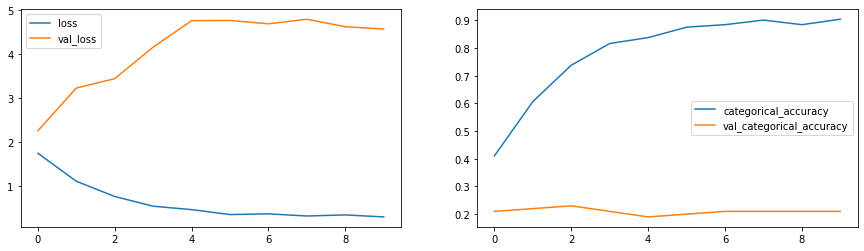

In [42]:
print("Per Epoch time  {}".format(conv3d_initial.timing_cb.logs))
print("Total Time: {}".format(sum(conv3d_initial.timing_cb.logs)))
plot(history_model_initial)

**Observation**
- The model is clearly overfitting, along with learning few inputs. This the 'initial' intended outcome.
- Now we will try to establish a baseline by running this over more epochs

### Step 3: 
We will now train the model with the above parameters for larger epochs and establish the baseline. As we have observed the model was overfitting, so we will add a droput layer in our baseline
Post that we will improve on our baseline by using various experiments


#### Model 1 ####
- Image - 160*160
- Batch Size - 40
- Num of Epochs - 15
- Dropouts - 0.25
- Dense Neurons - 128 -> 64

In [11]:
#Baseline Model Definition

class ModelConv3D1(BaseModel):
    
    def define_model(self, optimizer='Adam'):
        model = Sequential()
        model.add(Conv3D(16, (3,3,3), padding='same',
                        input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(32,(2,2,2), padding='same'))
        
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))
        
        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))
        
        model.add(Dense(self.num_classes,activation='softmax'))
        
        #optimizer = optimizers.Adam()
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [44]:
#Baseline Model
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_40 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_40 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_60 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_40 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_41 (Conv3D)           (None, 10, 80, 80, 32)    4128      
_________________________________________________________________
activation_41 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_61 (Batc (None, 10, 80, 80, 32)  

In [45]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 1.2656 - categorical_accuracy: 0.5385
Epoch 00001: val_loss improved from inf to 2.09538, saving model to model_initmodel-00001-1.26562-0.53846-2.09538--0.16000.h5
17/17 [==============================] - 47s 3s/step - loss: 1.2656 - categorical_accuracy: 0.5385 - val_loss: 2.0954 - val_categorical_accuracy: 0.1600
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 0.6286 - categorical_accuracy: 0.7466
Epoch 00002: val_loss did not improve from 2.09538
17/17 [==============================] - 47s 3s/step - loss: 0.6286 - categorical_accuracy: 0.7466 - val_loss: 3.7267 - val_categorical_accuracy: 0.1900
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 0.3597 - categorical_accuracy: 0.8854
Epoch 00003: val_loss did not improve from 2.09538
17/17 [==============================] - 46s 3s/step - loss: 0.3597 - categorical_accuracy: 0.8854 - val_loss: 5.1601 - val_ca

Per Epoch time  [48.443410543957725, 47.0588767810259, 45.9854645349551, 46.89694861904718, 46.58093414711766, 45.75921299494803, 46.87126227305271, 47.39489679806866, 45.93077138182707, 47.17846932611428, 46.183052195003256]
Total Time: 514.2832995951176


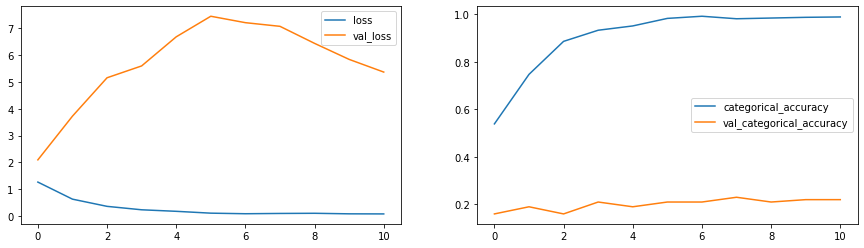

In [46]:
print("Per Epoch time  {}".format(conv_3d1.timing_cb.logs))
print("Total Time: {}".format(sum(conv_3d1.timing_cb.logs)))
plot(history_model1)

**Observation** 
- The baseline model is established. Clearly the model is overfitting, 
- We have an Val Accuracy of 0.16, and Val Loss of 2.09

#### Model 2 ####
We will try to add more  dense layers and combine it with dropouts to reduce overfitting
- Image - 160*160
- Batch Size - 40
- Num of Epochs - 25
- **Dropouts - 0.5**
- **Dense Neurons - 256 -> 256**

In [47]:
class ModelConv3D2(BaseModel):
    
    def define_model(self, optimizer='Adam', dense_neurons=64,dropout=0.25):
        model = Sequential()
        model.add(Conv3D(16, (3,3,3), padding='same',
                        input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(32,(2,2,2), padding='same'))
        
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes,activation='softmax'))
        
        #optimizer = optimizers.Adam()
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [48]:
conv_3d2=ModelConv3D2()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_44 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_44 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_66 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_44 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_45 (Conv3D)           (None, 10, 80, 80, 32)    4128      
_________________________________________________________________
activation_45 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_67 (Batc (None, 10, 80, 80, 32)  

In [49]:
print("Total Params:", conv_3d2_model.count_params())
history_model2 = conv_3d2.train_model(conv_3d2_model)

Total Params: 3434693
Epoch 1/25
17/17 [==============================] - ETA: 0s - loss: 1.6952 - categorical_accuracy: 0.4525
Epoch 00001: val_loss improved from inf to 2.28980, saving model to model_initmodel-00001-1.69522-0.45249-2.28980--0.25000.h5
17/17 [==============================] - 48s 3s/step - loss: 1.6952 - categorical_accuracy: 0.4525 - val_loss: 2.2898 - val_categorical_accuracy: 0.2500
Epoch 2/25
17/17 [==============================] - ETA: 0s - loss: 0.7923 - categorical_accuracy: 0.7225
Epoch 00002: val_loss did not improve from 2.28980
17/17 [==============================] - 47s 3s/step - loss: 0.7923 - categorical_accuracy: 0.7225 - val_loss: 4.8113 - val_categorical_accuracy: 0.1300
Epoch 3/25
17/17 [==============================] - ETA: 0s - loss: 0.5851 - categorical_accuracy: 0.7843
Epoch 00003: val_loss did not improve from 2.28980
17/17 [==============================] - 46s 3s/step - loss: 0.5851 - categorical_accuracy: 0.7843 - val_loss: 6.3515 - val_ca

Per Epoch time  [49.17469400516711, 46.977716160938144, 46.82993149594404, 46.76139936991967, 47.510705288965255, 44.96287687495351, 46.63955390499905, 46.59338922915049, 46.223739131120965, 46.749177190009505, 47.33959332690574]
Total Time: 515.7627759780735


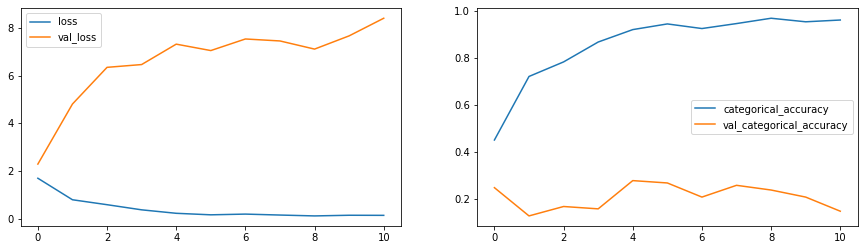

In [50]:
print("Per Epoch time  {}".format(conv_3d2.timing_cb.logs))
print("Total Time: {}".format(sum(conv_3d2.timing_cb.logs)))
plot(history_model2)

**Observation**:
  - The model is still not learning inspite droputs in fully connected layers
  - Accuracy has improved slightly possibly due to dense neurons
  - Validation loss is at 2.28 and Val Accuracy is at 0.25 which is much worse than the previous model


#### Model 3 ####
Possibly we need to add more data. We will try to increase the no of frames to see if there is a a better learning. If this works we can add augmentation to get more learning

- **Frames to Sample - 30**  
- Image - 160*160
- Batch Size - 40
- Num of Epochs - 25
- Dropouts - 0.25 - Dense layer
- Dense Neurons - 256

In [27]:
class ModelConv3D3(BaseModel):
    
    def define_model(self,dense_neurons,dropout,optimizer='Adam',filtersize=(3,3,3)):

        model = Sequential()
        model.add(Conv3D(16, (3,3,3), padding='same',
                        input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(32,(2,2,2), padding='same'))
        
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes,activation='softmax'))
        
        #optimizer = optimizers.Adam()
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model
        

In [30]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=160,image_width=160)
conv_3d3.initialize_hyperparams(frames_to_sample=30,batch_size=30,num_epochs=25)
conv_3d3_model=conv_3d3.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation_16 (Activation)   (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 15, 80, 80, 32)    4128      
_________________________________________________________________
activation_17 (Activation)   (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 15, 80, 80, 32)   

In [31]:
print("Total Params:", conv_3d3_model.count_params())
history_model3 = conv_3d3.train_model(conv_3d3_model)

Total Params: 3434693
Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 1.7802 - categorical_accuracy: 0.4389
Epoch 00001: val_loss improved from inf to 2.94034, saving model to model_initmodel-00001-1.78019-0.43891-2.94034--0.19000.h5
23/23 [==============================] - 79s 3s/step - loss: 1.7802 - categorical_accuracy: 0.4389 - val_loss: 2.9403 - val_categorical_accuracy: 0.1900
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 1.1763 - categorical_accuracy: 0.5867
Epoch 00002: val_loss did not improve from 2.94034
23/23 [==============================] - 80s 3s/step - loss: 1.1763 - categorical_accuracy: 0.5867 - val_loss: 4.0330 - val_categorical_accuracy: 0.2900
Epoch 3/25
23/23 [==============================] - ETA: 0s - loss: 0.9711 - categorical_accuracy: 0.6425
Epoch 00003: val_loss did not improve from 2.94034
23/23 [==============================] - 78s 3s/step - loss: 0.9711 - categorical_accuracy: 0.6425 - val_loss: 8.2182 - val_ca

In [ ]:
print("Per Epoch time  {}".format(conv_3d3.timing_cb.logs))
print("Total Time: {}".format(sum(conv_3d3.timing_cb.logs)))
plot(history_model3)

**Observation**

- Adding more data didnt improve the learning rate
- We will also reset the neurons at the dense layer to initial numbers
- We will now try to improve the learning by adding more layers
- Val Accuracy = 0.19 , Val loss = 2.94

#### Model 4 ####
Since we are not learning via complex dense layers, Its possible that features are not be convolved 
Lets add more Convolution layers to see if we get improved accuracy.

**Complexity Reduction** 
We also have increased the number of trainable parameters to 3M, which may not be effecient. 
So we will reduce the dense layers to 128 so trainable parameters drop to around 2-5 M. 
Also to increase effeciency, we will also start reducing frames to 20 

- **Reduce the no of frames to 20**
- Image - 160*160
- Batch Size - 40
- Num of Epochs - 25
- **Double the Conv Layers at each Convolution**
- Dropouts - 0.5 - Dense Layers
- **Dense Neurons - 128**

In [34]:
class ModelConv3D4(BaseModel):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        #model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        #model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        #model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        #model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [36]:
conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=160,image_width=160)
conv_3d4.initialize_hyperparams(frames_to_sample=20,batch_size=30,num_epochs=15)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=128,dropout=0.5)
conv_3d4_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_28 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_28 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_38 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
conv3d_29 (Conv3D)           (None, 20, 160, 160, 16)  6928      
_________________________________________________________________
activation_29 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_39 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_20 (MaxPooling (None, 10, 80, 80, 16)   

In [37]:
print("Total Params:", conv_3d4_model.count_params())
history_model4 = conv_3d4.train_model(conv_3d4_model)

Total Params: 2538229
Epoch 1/15
23/23 [==============================] - ETA: 0s - loss: 2.0049 - categorical_accuracy: 0.3484
Epoch 00001: val_loss improved from inf to 1.99711, saving model to model_initmodel-00001-2.00488-0.34842-1.99711--0.16000.h5
23/23 [==============================] - 50s 2s/step - loss: 2.0049 - categorical_accuracy: 0.3484 - val_loss: 1.9971 - val_categorical_accuracy: 0.1600
Epoch 2/15
23/23 [==============================] - ETA: 0s - loss: 1.7238 - categorical_accuracy: 0.4148
Epoch 00002: val_loss did not improve from 1.99711
23/23 [==============================] - 51s 2s/step - loss: 1.7238 - categorical_accuracy: 0.4148 - val_loss: 2.3548 - val_categorical_accuracy: 0.1800
Epoch 3/15
23/23 [==============================] - ETA: 0s - loss: 1.8778 - categorical_accuracy: 0.3831
Epoch 00003: val_loss did not improve from 1.99711
23/23 [==============================] - 51s 2s/step - loss: 1.8778 - categorical_accuracy: 0.3831 - val_loss: 3.0594 - val_ca

Per Epoch time  [33.30629811901599, 32.0571733340621, 31.25292151211761, 31.618457425152883, 31.61543852905743, 31.080252937041223, 32.24275181093253, 31.58912162994966, 31.77295049210079, 30.79807860706933, 30.985803109128028]
Total Time: 348.3192475056276


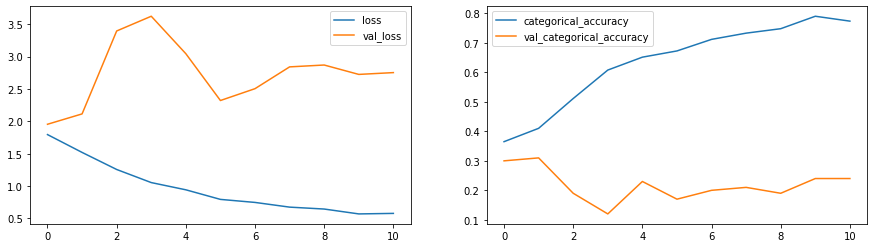

In [58]:
print("Per Epoch time  {}".format(conv_3d4.timing_cb.logs))
print("Total Time: {}".format(sum(conv_3d4.timing_cb.logs)))
plot(history_model4)

**Observation**

- Looks like the model is not learning even after adding multiple layers. So increasing epochs may not help
- We are **clearly** missing something

- Val Accuracy : 0.16
- Val Loss : 1.99
- We need to change the approach


#### Model 5 ####

The model has also become complex. Lets start afresh, and look at improving the way we convolve by using lower Neurons in the initial layers, and then increasing to higher neurons. So we are doing graded learning with 1 extra pixel on either side
We will also go back to learning by higher neurons in the dense layer
We will reduce the frames to 20, as we havent seen a significant difference at 30 frames

- Image - 120*120
- Batch Size - 40
- Num of Epochs - 25
- Dropouts - 0.25 - Each layer
- **Dense Neurons - 256 -> 128**
- Frames to Sample - ~30~, 20
- **Graded Neuron Increase Starting from a lower number**

In [52]:
class ModelConv3D5(BaseModel):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25, optimizer='Adam'):

        model = Sequential()
        model.add(Conv3D(8, (3,3,3), padding='same',
                        input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(16,filtersize, padding='same'))
        
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(32, filtersize, padding='same'))
        
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64,filtersize, padding='same'))
        
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(256,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
        
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes,activation='softmax'))
        
        #optimizer = optimizers.Adam()
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [50]:
conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=120,image_width=120)
conv_3d5.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=30)
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=128,dropout=0.5)
conv_3d5_model.summary()


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_60 (Conv3D)           (None, 30, 120, 120, 8)   656       
_________________________________________________________________
activation_60 (Activation)   (None, 30, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization_84 (Batc (None, 30, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_48 (MaxPooling (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_61 (Conv3D)           (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
activation_61 (Activation)   (None, 15, 60, 60, 16)    0         
_________________________________________________________________
batch_normalization_85 (Batc (None, 15, 60, 60, 16)  

In [51]:
print("Total Params:", conv_3d5_model.count_params())
history_model5 = conv_3d5.train_model(conv_3d5_model)

Total Params: 911973
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.8890 - categorical_accuracy: 0.3952
Epoch 00001: val_loss improved from inf to 2.06905, saving model to model_initmodel-00001-1.88900-0.39517-2.06905--0.25000.h5
34/34 [==============================] - 59s 2s/step - loss: 1.8890 - categorical_accuracy: 0.3952 - val_loss: 2.0690 - val_categorical_accuracy: 0.2500
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.5189 - categorical_accuracy: 0.4992
Epoch 00002: val_loss did not improve from 2.06905
34/34 [==============================] - 60s 2s/step - loss: 1.5189 - categorical_accuracy: 0.4992 - val_loss: 2.7053 - val_categorical_accuracy: 0.2500
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.2418 - categorical_accuracy: 0.5475
Epoch 00003: val_loss did not improve from 2.06905
34/34 [==============================] - 62s 2s/step - loss: 1.2418 - categorical_accuracy: 0.5475 - val_loss: 3.5439 - val_cat

Per Epoch time  [33.366906283888966, 31.631521177012473, 31.61272391001694, 31.45025938982144, 31.564692744985223, 31.737173584057018, 31.47920704097487, 31.727190957870334, 30.889083468122408, 31.546857743989676, 32.21243006084114]
Total Time: 349.2180463615805


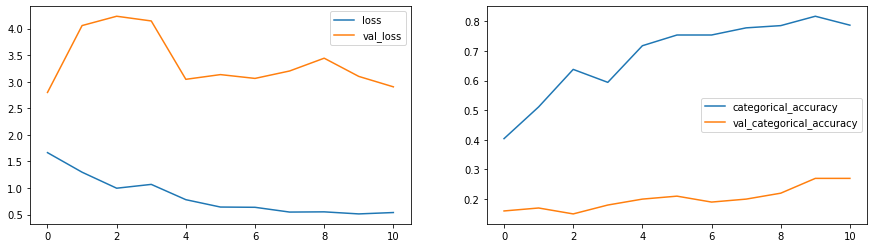

In [62]:
print("Per Epoch time  {}".format(conv_3d5.timing_cb.logs))
print("Total Time: {}".format(sum(conv_3d5.timing_cb.logs)))
plot(history_model5)

**Observation**

- There is slight improvement, and in the lower epochs looks like we are starting to learn
- Val Accuracy = 0.25, Val Loss=2.06
- **Complexity Reduction** - We are able to reduce the parameters to less then 1M, with comparable accuracy(of the previous runs). 
- This is a good outcome. We can use this model and we can try to build on it
- However we are still not learning fast enough. Looks like something is missed



#### Model 6 ####


**Hypothesis** : 
- If we assume we are convolving features, with a simple model, (We have tried to learn using multiple layers, and we are getting similar results) 
- If we assume we are doing good job of learning weights of Dense layers(We have tried doubling the dense layers with similar results)
- If we assume we have enough data to learn (We increased the frames to sample with similar size) 
Then the only area which we need to optimise is to increase the number of backpropagation and feedforward cycles. In the all the experiments above, we have tried to maximise data in one convolution. 
So lets try to increase the no of cycles now. We will build on top of Model 6 now, which is **simple and effecient**

Since learning is not adequate, we will try to decrease the batch size so there are more iterations of the model
Lets also tweak to  lower size images so that we get a 5*5 matrix in the end 

- **Image - 84*84**
- **Batch Size - ~40~ 10**
- Num of Epochs - 25
- Dropouts - 0.5 - Dense Layers
- Dense Neurons - 256*128
- Kernel Size - (3,3,3)

In [56]:
conv_3d6=ModelConv3D5()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height=84,image_width=84)
conv_3d6.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=30)
conv_3d6_model=conv_3d6.define_model(filtersize=(3,3,3),dropout=0.5)
conv_3d6_model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_72 (Conv3D)           (None, 30, 84, 84, 8)     656       
_________________________________________________________________
activation_72 (Activation)   (None, 30, 84, 84, 8)     0         
_________________________________________________________________
batch_normalization_102 (Bat (None, 30, 84, 84, 8)     32        
_________________________________________________________________
max_pooling3d_60 (MaxPooling (None, 15, 42, 42, 8)     0         
_________________________________________________________________
conv3d_73 (Conv3D)           (None, 15, 42, 42, 16)    3472      
_________________________________________________________________
activation_73 (Activation)   (None, 15, 42, 42, 16)    0         
_________________________________________________________________
batch_normalization_103 (Bat (None, 15, 42, 42, 16)  

In [57]:
print("Total Params:", conv_3d6_model.count_params())
history_model6 = conv_3d6.train_model(conv_3d6_model)

Total Params: 518757
Epoch 1/30
67/67 [==============================] - ETA: 0s - loss: 2.0331 - categorical_accuracy: 0.3363
Epoch 00001: val_loss improved from inf to 2.78580, saving model to model_initmodel-00001-2.03314-0.33635-2.78580--0.21000.h5
67/67 [==============================] - 64s 957ms/step - loss: 2.0331 - categorical_accuracy: 0.3363 - val_loss: 2.7858 - val_categorical_accuracy: 0.2100
Epoch 2/30
67/67 [==============================] - ETA: 0s - loss: 1.7322 - categorical_accuracy: 0.4012
Epoch 00002: val_loss did not improve from 2.78580
67/67 [==============================] - 63s 945ms/step - loss: 1.7322 - categorical_accuracy: 0.4012 - val_loss: 4.4908 - val_categorical_accuracy: 0.2100
Epoch 3/30
67/67 [==============================] - ETA: 0s - loss: 1.5207 - categorical_accuracy: 0.4555
Epoch 00003: val_loss did not improve from 2.78580
67/67 [==============================] - 64s 949ms/step - loss: 1.5207 - categorical_accuracy: 0.4555 - val_loss: 6.7406 

Per Epoch time  [65.1497939270921, 63.3907419918105, 63.63745254301466, 63.529379992047325, 62.744728971039876, 61.62952341302298, 61.440428133821115, 62.22927966201678, 64.29937398200855, 62.884203664027154, 64.04660155903548, 63.73842483689077, 64.23236973793246, 65.42667586402968, 63.16153504094109, 63.92791360616684, 64.68637071596459, 63.76515262504108, 63.379886087961495, 63.77771659987047, 63.51865138113499, 64.24383381288499, 63.665087837027386, 63.8423088779673, 63.72579849883914, 62.794054267928004, 63.710765581112355, 62.47218577796593, 64.36307009798475, 62.851206141058356]
Total Time: 1906.2645152276382


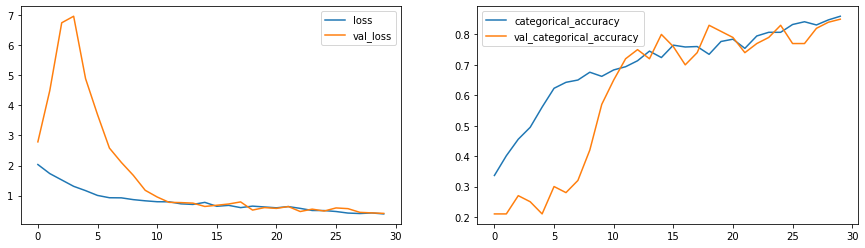

In [58]:
print("Per Epoch time  {}".format(conv_3d6.timing_cb.logs))
print("Total Time: {}".format(sum(conv_3d6.timing_cb.logs)))
plot(history_model6)

**Observation**

- Looks like we have figured out the problem, and the model looks **very promising**
- Looks like adding more batches results in more feedback loop and the model has optimum fit
- We also see continous improvement in each epoch and that shows that model is also learning in each epoch
    - ``Explanation``
    - With 10 batch size, we have around 66 Batches so 66 Feedforward loops which help in learning
      - Compare this with earlier batch size of 20, which creates 33 Feedforward loops only
- **Complexity Reduction**  - By reducing the image size, we have also brought the no of parameters to 0.5 Million. Looks like this model is for keeps
- Val Accuracy - 0.85, Val Loss - 0.4105



#### Model 7 ####
Lets try one final experiment to see if we can improve learning. We will start with Coarser Filters initially and then extend to finer filters. 
Also we will start with 16 neurons instead of 8 in line with the theme we have followed. 
We will build on top of **Model 6** 
- Image - 84*84
- Batch Size - 10
- **Num of Epochs - 50**
- Dropouts - 0.5 - Dense Layers
- **Dense Neurons - 128 -> 64**


In [12]:
class ModelConv3D7(BaseModel):
    
    
    def define_model(self, optimizer='Adam', dense_neurons=64,dropout=0.25):
        model = Sequential()
        model.add(Conv3D(16, (5,5,5), padding='same',
                        input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(32,(4,4,4), padding='same'))
        
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(64, (3, 3, 3), padding='same'))
        
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
        
        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes,activation='softmax'))
        
        #optimizer = optimizers.Adam()
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [13]:
conv_3d7=ModelConv3D7()
conv_3d7.initialize_path(project_folder)
conv_3d7.initialize_image_properties(image_height=84,image_width=84)
conv_3d7.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=50)
conv_3d7_model=conv_3d7.define_model(dense_neurons=256,dropout=0.5)
conv_3d7_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 84, 84, 16)    6016      
_________________________________________________________________
activation (Activation)      (None, 30, 84, 84, 16)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 84, 84, 16)    64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 42, 42, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 42, 42, 32)    32800     
_________________________________________________________________
activation_1 (Activation)    (None, 15, 42, 42, 32)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 42, 42, 32)    1

In [61]:
print("Total Params:", conv_3d7_model.count_params())
history_model7 = conv_3d7.train_model(conv_3d7_model)

Total Params: 579877
Epoch 1/50
67/67 [==============================] - ETA: 0s - loss: 2.0863 - categorical_accuracy: 0.3002
Epoch 00001: val_loss improved from inf to 4.78873, saving model to model_initmodel-00001-2.08626-0.30015-4.78873--0.20000.h5
67/67 [==============================] - 61s 910ms/step - loss: 2.0863 - categorical_accuracy: 0.3002 - val_loss: 4.7887 - val_categorical_accuracy: 0.2000
Epoch 2/50
67/67 [==============================] - ETA: 0s - loss: 1.8032 - categorical_accuracy: 0.3499
Epoch 00002: val_loss improved from 4.78873 to 1.51715, saving model to model_initmodel-00002-1.80323-0.34992-1.51715--0.35000.h5
67/67 [==============================] - 61s 909ms/step - loss: 1.8032 - categorical_accuracy: 0.3499 - val_loss: 1.5172 - val_categorical_accuracy: 0.3500
Epoch 3/50
67/67 [==============================] - ETA: 0s - loss: 1.6361 - categorical_accuracy: 0.3725
Epoch 00003: val_loss improved from 1.51715 to 1.45584, saving model to model_initmodel-00003

Per Epoch time  [62.29212944209576, 60.991513090906665, 61.10286291898228, 60.42207777313888, 61.467447587056085, 61.1141424709931, 60.568212165962905, 61.62703903391957, 60.990773730911314, 59.6412509130314, 59.81577779818326, 60.954562647035345, 60.61248716595583, 62.28627889882773, 60.92611822509207, 60.68032077210955, 60.6661163859535, 60.898639497114345, 60.61307732993737, 60.52377129299566, 61.014444421976805, 60.85325639997609, 61.6914257791359, 63.20421789889224, 61.532887558918446, 61.29969176417217, 61.80547109502368, 61.8627543640323, 61.83698192704469, 61.79482200415805, 61.206803906941786, 62.13353113294579, 60.39999582595192, 61.515267899027094, 60.03501140605658, 61.70972448308021, 61.0660858459305, 62.89613529690541, 60.474545285105705, 62.131870325189084, 62.138632885878906, 61.997170900925994, 61.937939633149654, 64.31839638086967, 61.247114535886794, 64.02649453398772]
Total Time: 2824.325272631366


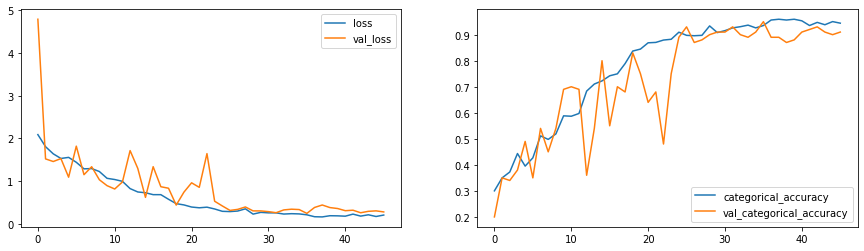

In [62]:
print("Per Epoch time  {}".format(conv_3d7.timing_cb.logs))
print("Total Time: {}".format(sum(conv_3d7.timing_cb.logs)))
plot(history_model7)

**Observation**

- The results are even better
- With little more coarse grained features, we are able to improve significantly by **10 percentage points**
- Also the Model is learning well and able to absorb most of the variations in the test data
- Higher Epochs helped absorb more of the learning
- Val Accuracy 0.95 - Val Loss - 0.24 


``This is the BEST MODEL for this configuration``

In [14]:
print("Total Params:", conv_3d7_model.count_params())
history_model7_aug = conv_3d7.train_model(conv_3d7_model, augment_data=True)

Total Params: 579877
Epoch 1/50
67/67 [==============================] - ETA: 0s - loss: 1.8355 - categorical_accuracy: 0.3816
Epoch 00001: val_loss improved from inf to 2.04412, saving model to model_initmodel-00001-1.83552-0.38160-2.04412--0.22000.h5
67/67 [==============================] - 159s 2s/step - loss: 1.8355 - categorical_accuracy: 0.3816 - val_loss: 2.0441 - val_categorical_accuracy: 0.2200
Epoch 2/50
67/67 [==============================] - ETA: 0s - loss: 1.5717 - categorical_accuracy: 0.4309
Epoch 00002: val_loss improved from 2.04412 to 2.03924, saving model to model_initmodel-00002-1.57175-0.43087-2.03924--0.30000.h5
67/67 [==============================] - 160s 2s/step - loss: 1.5717 - categorical_accuracy: 0.4309 - val_loss: 2.0392 - val_categorical_accuracy: 0.3000
Epoch 3/50
67/67 [==============================] - ETA: 0s - loss: 1.3114 - categorical_accuracy: 0.5053
Epoch 00003: val_loss improved from 2.03924 to 1.83772, saving model to model_initmodel-00003-1.3

### 2. -  CNN + LSTM Architecture
Looks like its time to move to the CNN - LSTM Model
A good reason to do is to take advantage of transfer learning, which can help improve the learning rate by using a pretrained Model

**Approach** 
- We will start with a basic CNN-RNN Model and establish a Baseline
- We will then experiment with various hyper parameters and try to find the best modes
- Finally we will apply transfer learning to figure out the best model

#### Model 8 ####
Baseline Model


In [12]:
class RNNCNN1(BaseModel):
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

            model = Sequential()

            model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                      input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
            model.add(TimeDistributed(BatchNormalization()))
            model.add(TimeDistributed(MaxPooling2D((2, 2))))

            model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
            model.add(TimeDistributed(BatchNormalization()))
            model.add(TimeDistributed(MaxPooling2D((2, 2))))

            model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
            model.add(TimeDistributed(BatchNormalization()))
            model.add(TimeDistributed(MaxPooling2D((2, 2))))

            model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
            model.add(TimeDistributed(BatchNormalization()))
            model.add(TimeDistributed(MaxPooling2D((2, 2))))

            #model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
            #model.add(TimeDistributed(BatchNormalization()))
            #model.add(TimeDistributed(MaxPooling2D((2, 2))))

            #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
            #model.add(TimeDistributed(BatchNormalization()))
            #model.add(TimeDistributed(MaxPooling2D((2, 2))))

            model.add(TimeDistributed(Flatten()))


            model.add(LSTM(lstm_cells))
            model.add(Dropout(dropout))

            model.add(Dense(dense_neurons,activation='relu'))
            model.add(Dropout(dropout))

            model.add(Dense(self.num_classes, activation='softmax'))
            optimiser = optimizers.Adam()
            model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
            return model

In [13]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=80,image_width=80)
rnn_cnn1.initialize_hyperparams(frames_to_sample=20,batch_size=10,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 20, 80, 80, 16)    448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 80, 80, 16)    64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 40, 40, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 40, 40, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 20, 40, 40, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 20, 20, 20, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 20, 20, 20, 64)    1

In [14]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model8=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1820005
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.3272 - categorical_accuracy: 0.4444
Epoch 00001: val_loss improved from inf to 1.99315, saving model to model_initmodel-00001-1.32723-0.44444-1.99315--0.23000.h5
67/67 [==============================] - 89s 1s/step - loss: 1.3272 - categorical_accuracy: 0.4444 - val_loss: 1.9931 - val_categorical_accuracy: 0.2300
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.0125 - categorical_accuracy: 0.6144
Epoch 00002: val_loss improved from 1.99315 to 1.71658, saving model to model_initmodel-00002-1.01248-0.61438-1.71658--0.22000.h5
67/67 [==============================] - 90s 1s/step - loss: 1.0125 - categorical_accuracy: 0.6144 - val_loss: 1.7166 - val_categorical_accuracy: 0.2200
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.7788 - categorical_accuracy: 0.7074
Epoch 00003: val_loss did not improve from 1.71658
67/67 [==============================] - 88s 1s

Per Epoch time  [94.05153739708476, 89.60309571889229, 88.50734278000891, 89.13482570787892, 88.68653670884669, 89.12336693983525, 89.19180541113019, 88.87885903194547, 87.84543136390857, 89.14796586404555, 87.20053446199745, 88.6169815978501, 87.78227030485868, 86.88399351807311, 85.58138534217142, 86.84775588382035, 86.62996127991937, 87.23577982094139, 87.1832558568567, 86.56721376092173]
Total Time: 1764.699898750987


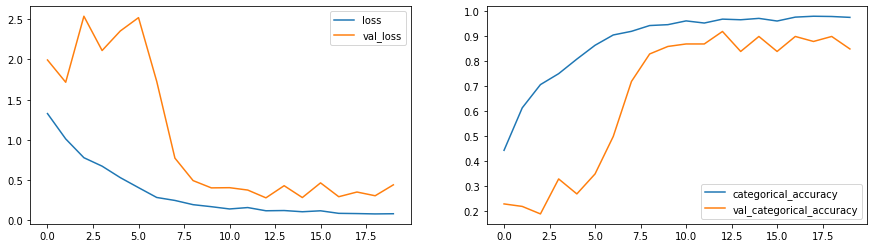

In [18]:
print("Per Epoch time  {}".format(rnn_cnn1.timing_cb.logs))
print("Total Time: {}".format(sum(rnn_cnn1.timing_cb.logs)))
plot(history_model8)

**Observation**
- CNNRNN Model learns quite well, and shows steady progress as the no of epochs increase
- Historical State makes it easier to learn as compared to a a plain CNN 3D model
- The time taken to train an epoch is still high, which we should try to reduce further
- Val Accuracy - 0.82, Val Loss - 0.46

### Model 9 ### 
CNN Model with GRU

In [16]:
class RNNCNN2(BaseModel):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
      

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [19]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=80,image_width=80)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_26 (TimeDis (None, 18, 80, 80, 16)    448       
_________________________________________________________________
time_distributed_27 (TimeDis (None, 18, 80, 80, 16)    64        
_________________________________________________________________
time_distributed_28 (TimeDis (None, 18, 40, 40, 16)    0         
_________________________________________________________________
time_distributed_29 (TimeDis (None, 18, 40, 40, 32)    4640      
_________________________________________________________________
time_distributed_30 (TimeDis (None, 18, 40, 40, 32)    128       
_________________________________________________________________
time_distributed_31 (TimeDis (None, 18, 20, 20, 32)    0         
_________________________________________________________________
time_distributed_32 (TimeDis (None, 18, 20, 20, 64)   

In [20]:

print("Total Params:", rnn_cnn2_model.count_params())
history_model9=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

Total Params: 1394277
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.3713 - categorical_accuracy: 0.4253
Epoch 00001: val_loss improved from inf to 1.72577, saving model to model_initmodel-00001-1.37128-0.42534-1.72577--0.21000.h5
34/34 [==============================] - 76s 2s/step - loss: 1.3713 - categorical_accuracy: 0.4253 - val_loss: 1.7258 - val_categorical_accuracy: 0.2100
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.9065 - categorical_accuracy: 0.6546
Epoch 00002: val_loss did not improve from 1.72577
34/34 [==============================] - 78s 2s/step - loss: 0.9065 - categorical_accuracy: 0.6546 - val_loss: 2.1302 - val_categorical_accuracy: 0.2100
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.7347 - categorical_accuracy: 0.7366
Epoch 00003: val_loss did not improve from 1.72577
34/34 [==============================] - 77s 2s/step - loss: 0.7347 - categorical_accuracy: 0.7366 - val_loss: 2.5339 - val_ca

Per Epoch time  [79.5516911779996, 78.395426500123, 77.07829180080444, 77.86237462516874, 76.67316366592422, 77.24835224892013, 76.46040706895292, 76.79566552280448, 77.19461024994962, 77.62289027590305, 76.2087994189933]
Total Time: 851.0916725555435


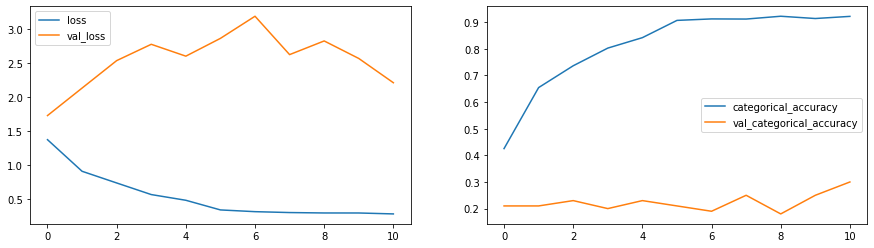

In [21]:
print("Per Epoch time  {}".format(rnn_cnn2.timing_cb.logs))
print("Total Time: {}".format(sum(rnn_cnn2.timing_cb.logs)))
plot(history_model9)

**Observation**

### Model 10 ###
CNN with Transfer Learning

In [ ]:
class ModelLSTM1(BaseModel):
    
    #We will also add a standard filtersize and dropout to generalize
    def define_model(self, optimiser='Adam'):
        
        base_model = VGG16(include_top=False, weights='imagenet', 
                         input_shape=(self.image_height,self.image_width,self.channels))  
                          
        x = base_model.output
        x = Flatten()(x)

        features = Dense(64, activation='relu')(x)
        conv_model = Model(inputs=base_model.input, outputs=features)
    
        for layer in base_model.layers:
            layer.trainable = False
        
        model = Sequential()
        model.add(TimeDistributed(conv_model, 
                    input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(GRU(32, return_sequences=True))
        model.add(GRU(16))
        model.add(Dropout(0.5))
        model.add(Dense(8, activation='relu'))
        model.add(Dense(5, activation='softmax'))

        #optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
plot(history_model9)

**Observation**

## Model 10 ##
CNN Model with Transfer Learning

In [ ]:
#Baseline
LSTM_initial = ModelLSTM1()
LSTM_initial.initialize_path(project_folder)
LSTM_initial.initialize_image_properties(image_height=100, image_width=100)
LSTM_initial.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=10)
LSTM_initial_model = LSTM_initial.define_model()
LSTM_initial_model.summary()
LSTM_initial.train_model(LSTM_initial_model)
print("Per Epoch time  {}".format(LSTM_initial.timing_cb.logs))
print("Total Time: {}".format(sum(LSTM_initial.timing_cb.logs)))


## Conclusion ## 
- **MODEL 5** for CNN3D Model
- **TO DECIDE** is the Best CNNRNN Model